## Loading the libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from requests import get
from bs4 import BeautifulSoup
import re
from time import sleep
from wordcloud import WordCloud
from random import randint
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

## Scraping from the web page

In [2]:
# Getting English translated titles from the movies
headers = {'Accept-Language': 'en-US, en;q=0.5'}

In [3]:
pages = np.arange(1, 1001, 50)
pages

array([  1,  51, 101, 151, 201, 251, 301, 351, 401, 451, 501, 551, 601,
       651, 701, 751, 801, 851, 901, 951])

In [4]:
# URLs for top and bottom movies
urls = ['https://www.imdb.com/search/title/?groups=top_1000&start=', 'https://www.imdb.com/search/title/?groups=bottom_1000&start=']
titles = []
years = []
time = []
imdb_ratings = []
metascores = []
votes = []
us_gross = []
descriptions = []

for url in urls:
    for page in pages:
        # Getting the contents from each URL
        page = requests.get(url + str(page), headers=headers)
        soup = BeautifulSoup(page.text, 'html.parser')

        # Aiming the part of the HTML we want to get the information from
        movie_div = soup.find_all('div', class_='lister-item mode-advanced')

        # Controlling the loop’s rate by pausing the execution for a specified amount of time
        # Waiting time between requests for a number between 2-10 seconds
        sleep(randint(2, 10))

        for container in movie_div:
            # Scraping the movie's name
            name = container.h3.a.text
            titles.append(name)

            # Scraping the movie's year
            year = container.h3.find('span', class_='lister-item-year').text
            years.append(year)

            # Scraping the movie's length
            runtime = container.find('span', class_='runtime').text if container.find('span', class_='runtime') else '-'
            time.append(runtime)

            # Scraping the rating
            imdb = float(container.strong.text)
            imdb_ratings.append(imdb)

            # Scraping the metascore
            m_score = container.find('span', class_='metascore').text.strip() if container.find('span', class_='metascore') else '-'
            metascores.append(m_score)

            # Scraping votes and gross earnings
            nv = container.find_all('span', attrs={'name': 'nv'})
            vote = nv[0]['data-value']
            votes.append(vote)
            grosses = nv[1]['data-value'] if len(nv) > 1 else '-'
            us_gross.append(grosses)

            # Scraping the review
            review = container.find_all('p', class_='text-muted')[-1].text
            descriptions.append(review)

## Creating the Data Set

In [5]:
movies = pd.DataFrame({'movie':titles,
                       'year':years,
                       'time_minute':time,
                       'imdb_rating':imdb_ratings,
                       'metascore':metascores,
                       'vote':votes,
                       'gross_earning':us_gross,
                       'discription':descriptions})

movies.head()

,movie,year,time_minute,imdb_rating,metascore,vote,gross_earning,discription
0,Guardians of the Galaxy Vol. 3,(2023),150 min,8.3,64,110612,140,"\nStill reeling from the loss of Gamora, Peter..."
1,Guardians of the Galaxy,(2014),121 min,8.0,76,1211067,"333,176,600",\nA group of intergalactic criminals must pull...
2,John Wick: Chapter 4,(2023),169 min,8.2,78,147830,200,\nJohn Wick uncovers a path to defeating The H...
3,Guardians of the Galaxy Vol. 2,(2017),136 min,7.6,67,708845,"389,813,101",\nThe Guardians struggle to keep together as a...
4,Dune,(2021),155 min,8.0,74,673123,"108,327,830",\nA noble family becomes embroiled in a war fo...


In [ ]:
movies.head()

,movie,year,time_minute,imdb_rating,metascore,vote,gross_earning,discription
0,Guardians of the Galaxy Vol. 3,(2023),150 min,8.3,64,109612,140,"\nStill reeling from the loss of Gamora, Peter..."
1,Guardians of the Galaxy,(2014),121 min,8.0,76,1210928,"333,176,600",\nA group of intergalactic criminals must pull...
2,John Wick: Chapter 4,(2023),169 min,8.2,78,147692,200,\nJohn Wick uncovers a path to defeating The H...
3,Guardians of the Galaxy Vol. 2,(2017),136 min,7.6,67,708701,"389,813,101",\nThe Guardians struggle to keep together as a...
4,Dune,(2021),155 min,8.0,74,673034,"108,327,830",\nA noble family becomes embroiled in a war fo...


**Saving Data**

In [6]:
movies.to_csv('movies.csv', index=False)

**EDA**

In [ ]:
movies['discription'].head()

0    \nStill reeling from the loss of Gamora, Peter...
1    \nA group of intergalactic criminals must pull...
2    \nJohn Wick uncovers a path to defeating The H...
3    \nThe Guardians struggle to keep together as a...
4    \nA noble family becomes embroiled in a war fo...
Name: discription, dtype: object

In [ ]:
movies.dtypes

movie             object
year              object
time_minute       object
imdb_rating      float64
metascore         object
vote              object
gross_earning     object
discription       object
dtype: object

## Cleaning the Data Set

In [ ]:
# Cleaning 'year' column
movies['year'] = movies['year'].str.extract('(\d+)').astype(int)
movies.head(3)

,movie,year,time_minute,imdb_rating,metascore,vote,gross_earning,discription
0,Guardians of the Galaxy Vol. 3,2023,150 min,8.3,64,109612,140,"\nStill reeling from the loss of Gamora, Peter..."
1,Guardians of the Galaxy,2014,121 min,8.0,76,1210928,"333,176,600",\nA group of intergalactic criminals must pull...
2,John Wick: Chapter 4,2023,169 min,8.2,78,147692,200,\nJohn Wick uncovers a path to defeating The H...


In [ ]:
# Cleaning 'time_minute' column
movies['time_minute'] = movies['time_minute'].str.extract('(\d+)').astype(int)
movies.head(3)

,movie,year,time_minute,imdb_rating,metascore,vote,gross_earning,discription
0,Guardians of the Galaxy Vol. 3,2023,150,8.3,64,109612,140,"\nStill reeling from the loss of Gamora, Peter..."
1,Guardians of the Galaxy,2014,121,8.0,76,1210928,"333,176,600",\nA group of intergalactic criminals must pull...
2,John Wick: Chapter 4,2023,169,8.2,78,147692,200,\nJohn Wick uncovers a path to defeating The H...


In [ ]:
# Cleaning 'metascore' column
movies['metascore'] = movies['metascore'].str.extract('(\d+)')
# convert it to float and if there are dashes turn it into NaN
movies['metascore'] = pd.to_numeric(movies['metascore'], errors='coerce')

In [ ]:
# Cleaning 'vote' column
movies['vote'] = movies['vote'].str.replace(',', '').astype(int)
movies.head(3)

,movie,year,time_minute,imdb_rating,metascore,vote,gross_earning,discription
0,Guardians of the Galaxy Vol. 3,2023,150,8.3,64.0,109612,140,"\nStill reeling from the loss of Gamora, Peter..."
1,Guardians of the Galaxy,2014,121,8.0,76.0,1210928,"333,176,600",\nA group of intergalactic criminals must pull...
2,John Wick: Chapter 4,2023,169,8.2,78.0,147692,200,\nJohn Wick uncovers a path to defeating The H...


In [ ]:
# Remove commas from the values
movies['gross_earning'] = movies['gross_earning'].str.replace(',', '')

# Convert the values to float
movies['gross_earning'] = pd.to_numeric(movies['gross_earning'], errors='coerce')

In [ ]:
movies['gross_earning'].head()

0          140.0
1    333176600.0
2          200.0
3    389813101.0
4    108327830.0
Name: gross_earning, dtype: float64

In [ ]:
# Replace 3-digit values with NaN
movies.loc[movies['gross_earning'].apply(lambda x:  len(str(x)) < 8), 'gross_earning'] = np.nan

In [ ]:
movies['gross_earning'].head()

0            NaN
1    333176600.0
2            NaN
3    389813101.0
4    108327830.0
Name: gross_earning, dtype: float64

In [ ]:
movies.dtypes

movie             object
year               int64
time_minute        int64
imdb_rating      float64
metascore        float64
vote               int64
gross_earning    float64
discription       object
dtype: object

In [ ]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movie          2000 non-null   object 
 1   year           2000 non-null   int64  
 2   time_minute    2000 non-null   int64  
 3   imdb_rating    2000 non-null   float64
 4   metascore      1663 non-null   float64
 5   vote           2000 non-null   int64  
 6   gross_earning  1456 non-null   float64
 7   discription    2000 non-null   object 
dtypes: float64(3), int64(3), object(2)
memory usage: 125.1+ KB


In [ ]:
movies.describe()

,year,time_minute,imdb_rating,metascore,vote,gross_earning
count,2000.000000,2000.000000,2000.000000,1663.000000,2.000000e+03,1.456000e+03
mean,1999.790000,111.927500,6.322100,56.742032,1.785591e+05,5.534253e+07
std,20.192468,26.134436,1.750435,25.528733,3.043137e+05,9.288657e+07
min,1920.000000,45.000000,1.200000,1.000000,1.033200e+04,1.001190e+05
25%,1993.000000,93.000000,4.900000,34.000000,2.606900e+04,6.707589e+06
50%,2006.000000,104.000000,7.200000,57.000000,5.510800e+04,2.344062e+07
75%,2014.000000,125.000000,7.900000,80.000000,1.714642e+05,5.864940e+07
max,2023.000000,321.000000,9.300000,100.000000,2.739736e+06,9.366622e+08


Top Movies with Top gross_earning

In [ ]:
# Sort the DataFrame by 'gross_earning' in descending order
sorted_df = movies.sort_values(by='gross_earning', ascending=False)

# Print the movies with top grossing
top_movies = sorted_df.head()
print(top_movies)

                                          movie  year  time_minute  \
106  Star Wars: Episode VII - The Force Awakens  2015          138   
15                            Avengers: Endgame  2019          181   
16                      Spider-Man: No Way Home  2021          148   
59                                       Avatar  2009          162   
9                             Top Gun: Maverick  2022          130   

     imdb_rating  metascore     vote  gross_earning  \
106          7.8       80.0   946168    936662225.0   
15           8.4       78.0  1175788    858373000.0   
16           8.2       71.0   793066    804747988.0   
59           7.9       83.0  1340536    760507625.0   
9            8.3       78.0   583486    718732821.0   

                                           discription  
106  \nAs a new threat to the galaxy rises, Rey, a ...  
15   \nAfter the devastating events of Avengers: In...  
16   \nWith Spider-Man's identity now revealed, Pet...  
59   \nA paraplegic 

Bottom Movies with gross_earning

In [ ]:
# Sort the DataFrame by 'gross_earning' in ascending order
sorted_df = movies.sort_values(by='gross_earning')

# Print the movies with bottom grossing
bottom_movies = sorted_df.head()
print(bottom_movies)

                                movie  year  time_minute  imdb_rating  \
940   Elite Squad 2: The Enemy Within  2010          115          8.0   
898                  The Way He Looks  2014           96          7.9   
1718             Survival of the Dead  2009           90          4.8   
821                     Andrei Rublev  1966          205          8.1   
1819                    The Romantics  2010           95          5.0   

      metascore   vote  gross_earning  \
940        71.0  84667       100119.0   
898        71.0  26405       101137.0   
1718       43.0  21990       101740.0   
821         NaN  55136       102021.0   
1819       43.0  12358       103280.0   

                                            discription  
940   \nAfter a prison riot, former-Captain Nascimen...  
898   \nLeonardo is a blind teenager searching for i...  
1718  \nOn an island off the coast of North America,...  
821   \nThe life, times and afflictions of the fifte...  
1819  \nSeven close frie

**Movies with Top Rating**

In [ ]:
# Sort the DataFrame by 'Top Rating' in ascending order
sorted_df = movies.sort_values(by='imdb_rating',ascending=False)

# Print the movies with bottom grossing
bottom_movies = sorted_df.head()
print(bottom_movies)

                       movie  year  time_minute  imdb_rating  metascore  \
7   The Shawshank Redemption  1994          142          9.3       82.0   
10             The Godfather  1972          175          9.2      100.0   
90              12 Angry Men  1957           96          9.0       97.0   
53          Schindler's List  1993          195          9.0       95.0   
17           The Dark Knight  2008          152          9.0       84.0   

       vote  gross_earning                                        discription  
7   2739736     28341469.0  \nOver the course of several years, two convic...  
10  1905197    134966411.0  \nDon Vito Corleone, head of a mafia family, d...  
90   810948      4360000.0  \nThe jury in a New York City murder trial is ...  
53  1382714     96898818.0  \nIn German-occupied Poland during World War I...  
17  2712707    534858444.0  \nWhen the menace known as the Joker wreaks ha...  


**Movies with Bottom Rating**

In [ ]:
# Sort the DataFrame by 'Bottom Rating' in ascending order
sorted_df = movies.sort_values(by='imdb_rating', ascending=True)

# Print the movies with the lowest IMDb ratings
bottom_movies = sorted_df.head()
print(bottom_movies)

                                movie  year  time_minute  imdb_rating  \
1918                Daniel the Wizard  2004           81          1.2   
1981                         Smolensk  2016          120          1.2   
1672                       Foodfight!  2012           91          1.3   
1875  Kirk Cameron's Saving Christmas  2014           79          1.3   
1974                   Turks in Space  2006          110          1.5   

      metascore   vote  gross_earning  \
1918        NaN  14566            NaN   
1981        NaN  39889            NaN   
1672        NaN  11368            NaN   
1875       18.0  16356      2783970.0   
1974        NaN  16464            NaN   

                                            discription  
1918  \nEvil assassins want to kill Daniel Kublbock,...  
1981  \nAn inspired story of people affected by the ...  
1672  \nThe evil Brand X joins a supermarket that be...  
1875  \nHis annual Christmas party faltering thanks ...  
1974  \nA family of Turk

## Final Data Set

In [ ]:
movies

,movie,year,time_minute,imdb_rating,metascore,vote,gross_earning,discription
0,Guardians of the Galaxy Vol. 3,2023,150,8.3,64.0,109612,NaN,"\nStill reeling from the loss of Gamora, Peter..."
1,Guardians of the Galaxy,2014,121,8.0,76.0,1210928,333176600.0,\nA group of intergalactic criminals must pull...
2,John Wick: Chapter 4,2023,169,8.2,78.0,147692,NaN,\nJohn Wick uncovers a path to defeating The H...
3,Guardians of the Galaxy Vol. 2,2017,136,7.6,67.0,708701,389813101.0,\nThe Guardians struggle to keep together as a...
4,Dune,2021,155,8.0,74.0,673034,108327830.0,\nA noble family becomes embroiled in a war fo...
...,...,...,...,...,...,...,...,...
1995,Bhuj: The Pride of India,2021,113,4.2,NaN,24696,NaN,"\nDuring the Indo-Pakistani War of 1971, the B..."
1996,Dabangg 2,2012,120,4.8,NaN,19235,2519190.0,\nChulbul Pandey invites a fresh trouble when ...
1997,Recep Ivedik 2,2009,107,4.4,NaN,21787,NaN,\nRecep gets a job and tries to find a wife to...
1998,Recep Ivedik 5,2017,114,3.3,NaN,17134,NaN,\nRecep continues his adventure with internati...


<h1>Sentiment Analysis</h1>

**Creating a new column Review on the basis of Rating**

In [ ]:
# Create the 'review' column based on the 'Rating' column
movies['review'] = movies['imdb_rating'].apply(lambda x: 'positive' if x > 5 else 'negative')
movies.head()

,movie,year,time_minute,imdb_rating,metascore,vote,gross_earning,discription,review
0,Guardians of the Galaxy Vol. 3,2023,150,8.3,64.0,109612,NaN,"\nStill reeling from the loss of Gamora, Peter...",positive
1,Guardians of the Galaxy,2014,121,8.0,76.0,1210928,333176600.0,\nA group of intergalactic criminals must pull...,positive
2,John Wick: Chapter 4,2023,169,8.2,78.0,147692,NaN,\nJohn Wick uncovers a path to defeating The H...,positive
3,Guardians of the Galaxy Vol. 2,2017,136,7.6,67.0,708701,389813101.0,\nThe Guardians struggle to keep together as a...,positive
4,Dune,2021,155,8.0,74.0,673034,108327830.0,\nA noble family becomes embroiled in a war fo...,positive


In [ ]:
# changing the review column to 0 and 1
movies['review'] = movies['review'].apply(lambda x: 1 if x =="positive" else 0)
movies.head()

,movie,year,time_minute,imdb_rating,metascore,vote,gross_earning,discription,review
0,Guardians of the Galaxy Vol. 3,2023,150,8.3,64.0,109612,NaN,"\nStill reeling from the loss of Gamora, Peter...",1
1,Guardians of the Galaxy,2014,121,8.0,76.0,1210928,333176600.0,\nA group of intergalactic criminals must pull...,1
2,John Wick: Chapter 4,2023,169,8.2,78.0,147692,NaN,\nJohn Wick uncovers a path to defeating The H...,1
3,Guardians of the Galaxy Vol. 2,2017,136,7.6,67.0,708701,389813101.0,\nThe Guardians struggle to keep together as a...,1
4,Dune,2021,155,8.0,74.0,673034,108327830.0,\nA noble family becomes embroiled in a war fo...,1


**Selected only Required Variables for our Sentiment Analysis**

In [ ]:
#select only the "review" and "description" columns from a DataFrame called "movies," 
movies = movies[['review', 'discription']]

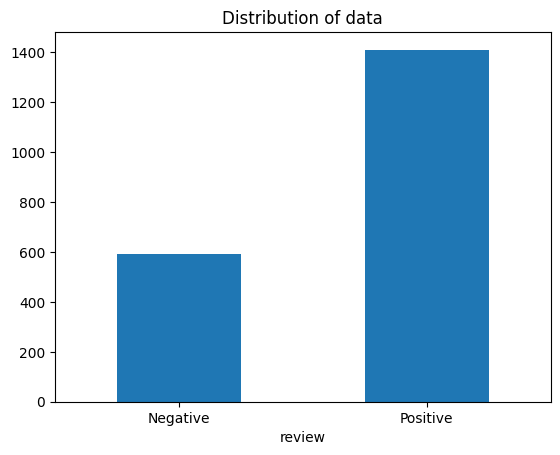

In [ ]:
# Plotting the distribution for dataset.
ax = movies.groupby('review').count().plot(kind='bar', title='Distribution of data',legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)
# Storing data in lists.
text, sentiment = list(movies['discription']), list(movies['review'])

In [ ]:
movies.fillna(movies.median(), inplace=True)

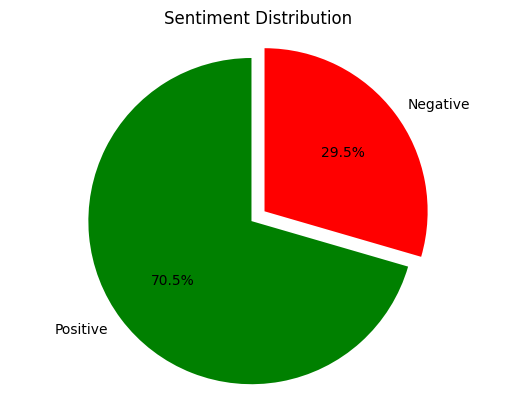

In [ ]:
# Counting the number of positive and negative reviews
positive_count = movies['review'].value_counts()[1]
negative_count = movies['review'].value_counts()[0]

# Creating the pie chart
labels = ['Positive', 'Negative']
sizes = [positive_count, negative_count]
colors = ['green', 'red']
explode = (0.1, 0)  # Explode the positive slice slightly

fig, ax = plt.subplots()
ax.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
ax.set_title('Sentiment Distribution')

plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()

<Axes: xlabel='review', ylabel='count'>

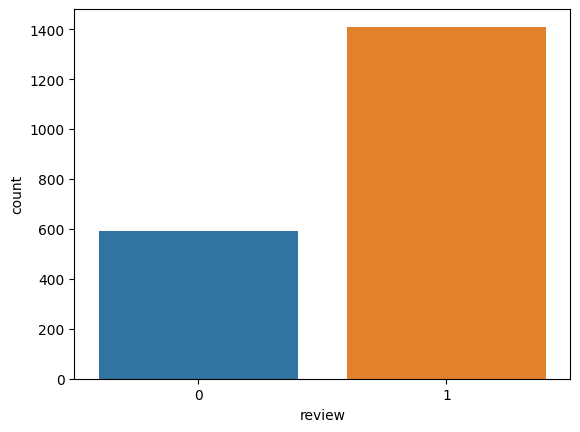

In [ ]:
import seaborn as sns
sns.countplot(x='review', data=movies)

Stop words are commonly used words in a language that are considered to have little or no significance in determining the meaning of a text. Examples of stop words in English include "a," "an," "the," "in," "on," "is," etc. 

In [ ]:
# Download stopwords if not already downloaded
nltk.download('stopwords')
nltk.download('punkt')
# Get the list of stopwords
stop_words = set(stopwords.words('english'))

# Function to remove stopwords from a text
def remove_stopwords(text):
    tokens = word_tokenize(text)  # Tokenize the text
    filtered_tokens = [token for token in tokens if token.lower() not in stop_words]  # Remove stopwords
    filtered_text = ' '.join(filtered_tokens)  # Reconstruct the text
    return filtered_text

# Apply the remove_stopwords function to the 'description' column
movies['discription'] = movies['discription'].apply(remove_stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!



Removing punctuation marks from text is a common preprocessing step in natural language processing tasks. Punctuation marks include characters such as periods, commas, question marks, exclamation marks, and quotation marks. Removing punctuation can help simplify text and reduce noise that may not contribute to the meaning of the text.

In [ ]:
import string
# Function to remove punctuation from a text
def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)  # Create a translation table for punctuation
    text_without_punct = text.translate(translator)  # Remove punctuation using the translation table
    return text_without_punct

# Apply the remove_punctuation function to the 'description' column
movies['discription'] = movies['discription'].apply(remove_punctuation)

Removing numbers

In [ ]:
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
movies['discription'] = movies['discription'].apply(cleaning_numbers)
movies['discription'].tail()

1995    IndoPakistani War   Bhuj airbase attacked race...
1996    Chulbul Pandey invites fresh trouble kills bro...
1997    Recep gets job tries find wife please ailing g...
1998    Recep continues adventure international athlet...
1999    Recep Ivedik coaches children football team ne...
Name: discription, dtype: object

Lemmatization is the process of reducing words to their base or root form, known as a lemma. It involves identifying the canonical form of a word, considering its intended meaning and context.
<br>
For example, let's consider the word "running." The lemma for this word, obtained through lemmatization, would be "run." Similarly, for words like "better," "best," and "good," the lemmatization process would map them to their lemma "good."

In [ ]:
lm = nltk.WordNetLemmatizer()
nltk.download('wordnet')
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data
movies['discription'] = movies['discription'].apply(lambda x: lemmatizer_on_text(x))
movies['discription'].head()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


0    Still reeling loss Gamora  Peter Quill rallies...
1    group intergalactic criminals must pull togeth...
2    John Wick uncovers path defeating High Table  ...
3    Guardians struggle keep together team dealing ...
4    noble family becomes embroiled war control gal...
Name: discription, dtype: object

In [ ]:
X=movies.discription
y=movies.review

**Most Words used in Negative feedback movies**

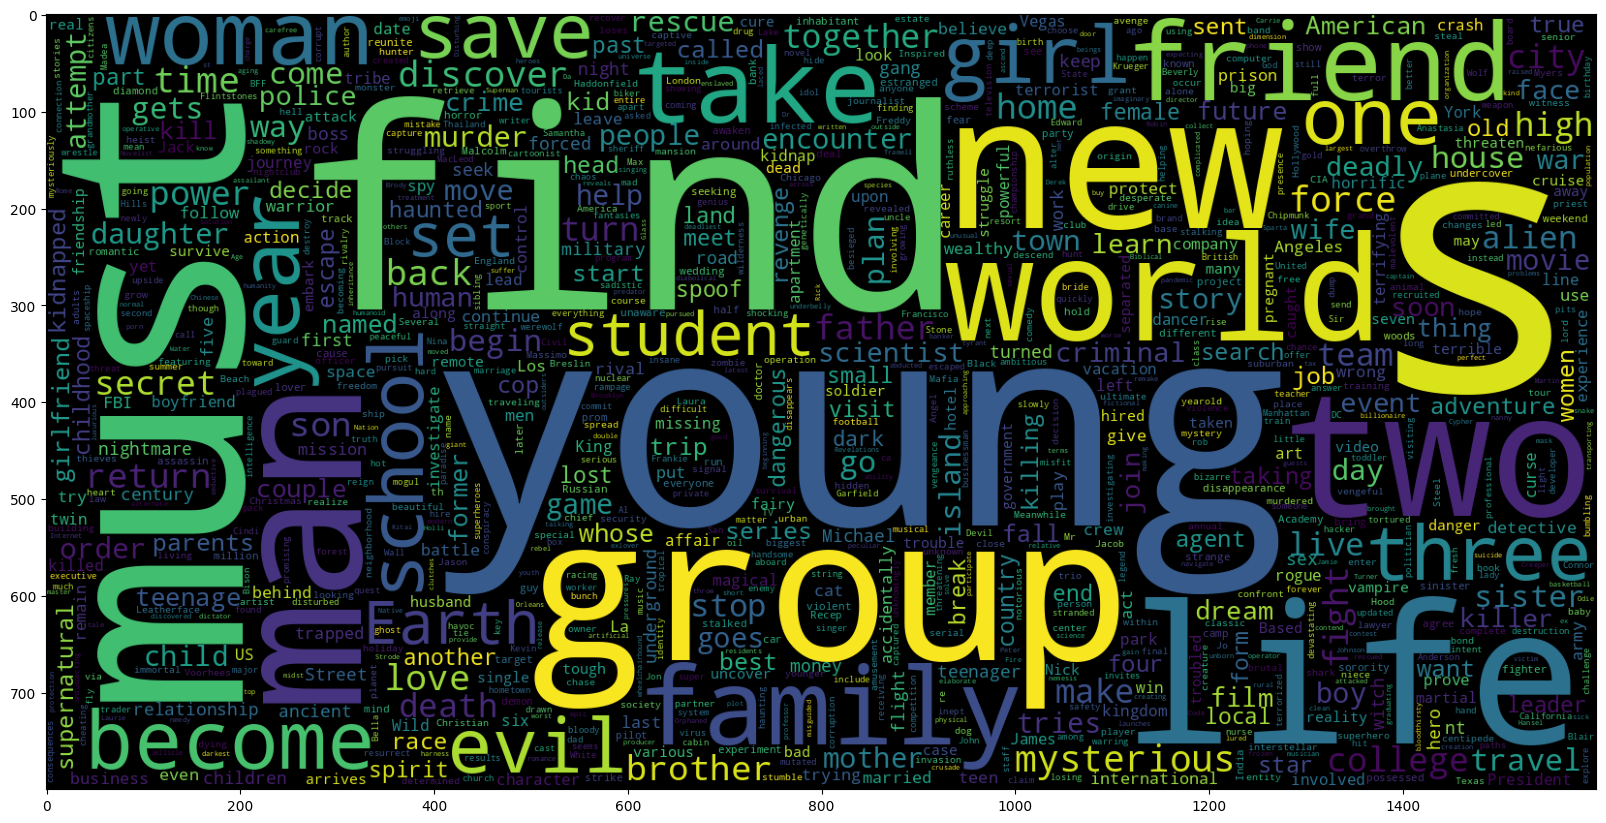

In [ ]:
data_neg = movies[movies['review'] == 0]['discription']
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

**Most Words used in Positive feedback movies**

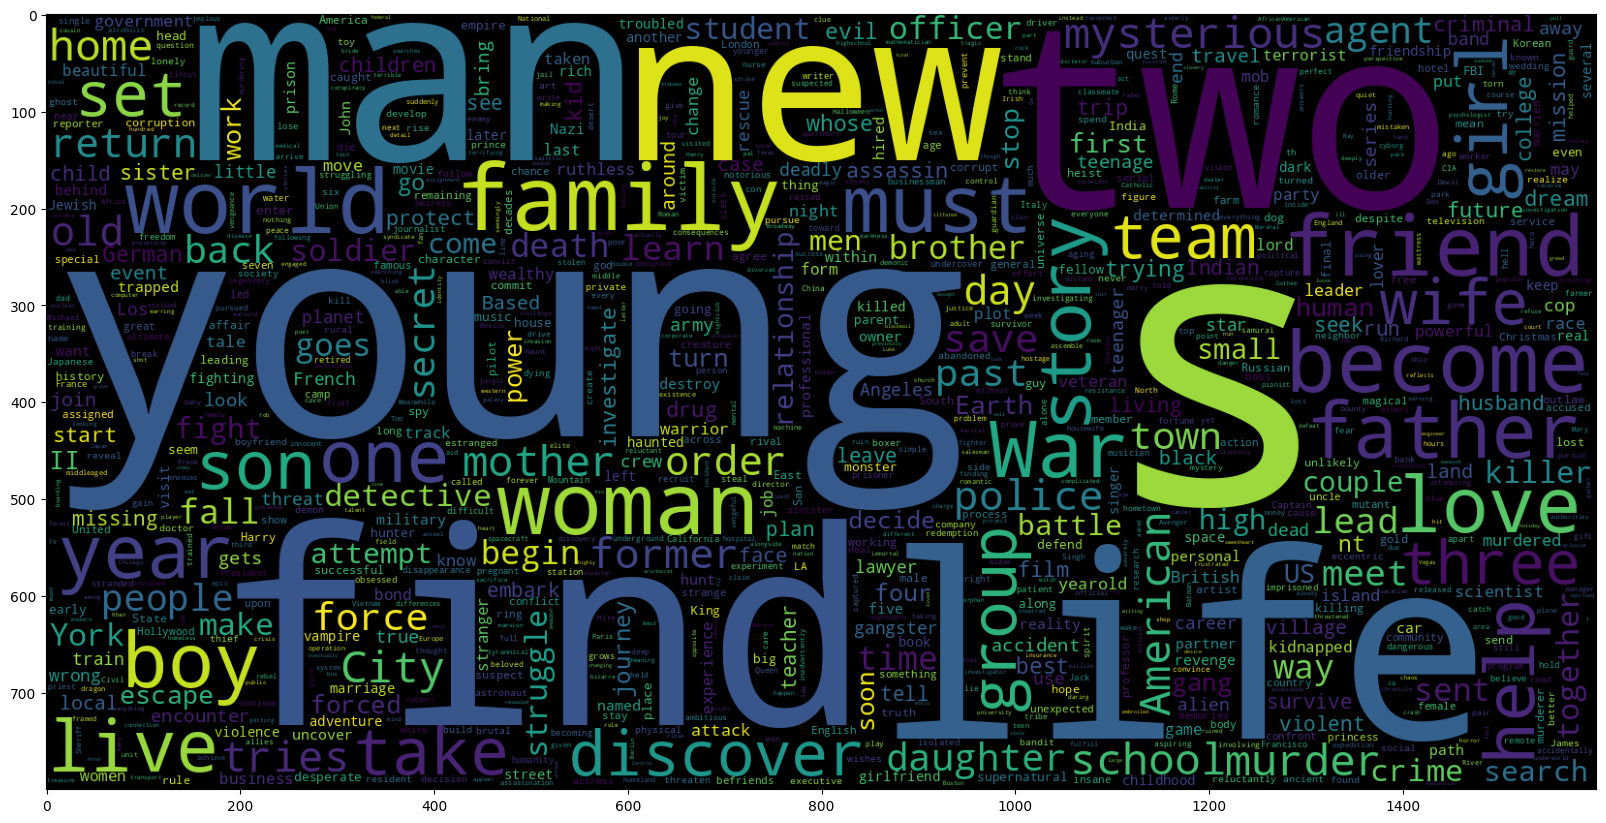

In [ ]:
data_pos = movies[movies['review'] == 1]['discription']
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_pos))
plt.imshow(wc)

**Train Test Split**

In [ ]:
# Separating the 80% data for training data and 20% for testing data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state =26105111)

Converting a collection of raw documents into a matrix of TF-IDF (Term Frequency-Inverse Document Frequency) features.

In [ ]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print('No. of feature_words: ', len(vectoriser.get_feature_names_out()))

No. of feature_words:  28474


In [ ]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)

**Evaluation Function**





In [ ]:
def model_Evaluate(model):
  # Predict values for Test dataset
  y_pred = model.predict(X_test)
  # Print the evaluation metrics for the dataset.
  print(classification_report(y_test, y_pred))
  # Compute and plot the Confusion matrix
  cf_matrix = confusion_matrix(y_test, y_pred)
  categories = ['Negative','Positive']
  group_names = ['True Neg','False Pos', 'False Neg','True Pos']
  group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
  labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
  xticklabels = categories, yticklabels = categories)
  plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
  plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
  plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

**Naive Bayes**

Naive Bayes is a classification algorithm based on Bayes' theorem, which is a probabilistic approach for making predictions. The "naive" assumption in Naive Bayes refers to the assumption of independence between features, meaning that the presence or absence of a particular feature does not depend on the presence or absence of any other feature.

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       105
           1       0.74      1.00      0.85       295

    accuracy                           0.74       400
   macro avg       0.37      0.50      0.42       400
weighted avg       0.54      0.74      0.63       400



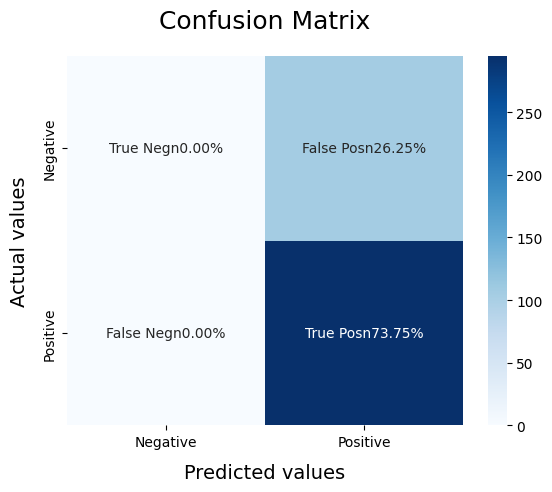

In [ ]:
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)
y_pred1 = BNBmodel.predict(X_test)

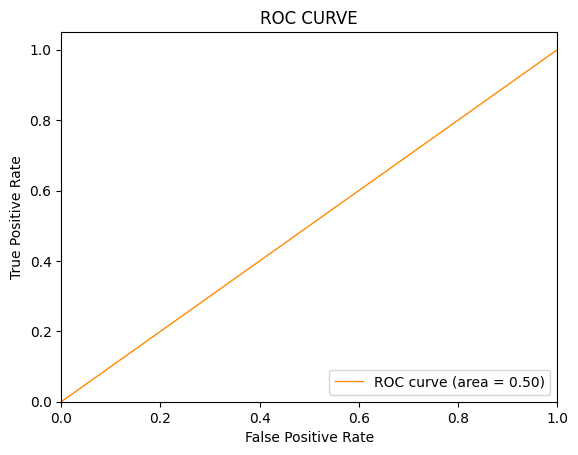

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

**Logistic Regression**

Logistic Regression is a statistical modeling technique used for binary classification tasks. It predicts the probability of an instance belonging to a particular class. Despite its name, logistic regression is a classification algorithm rather than a regression algorithm.

In logistic regression, the dependent variable is binary or categorical, and the independent variables can be continuous or categorical. The goal is to find a relationship between the independent variables and the probability of the binary outcome.

              precision    recall  f1-score   support

           0       0.60      0.03      0.05       105
           1       0.74      0.99      0.85       295

    accuracy                           0.74       400
   macro avg       0.67      0.51      0.45       400
weighted avg       0.70      0.74      0.64       400



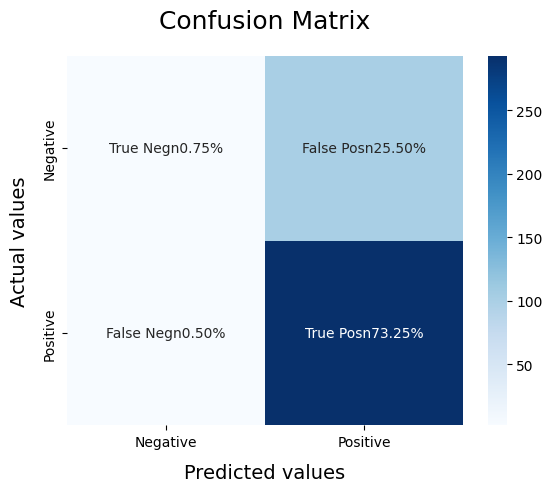

In [ ]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)
y_pred3 = LRmodel.predict(X_test)

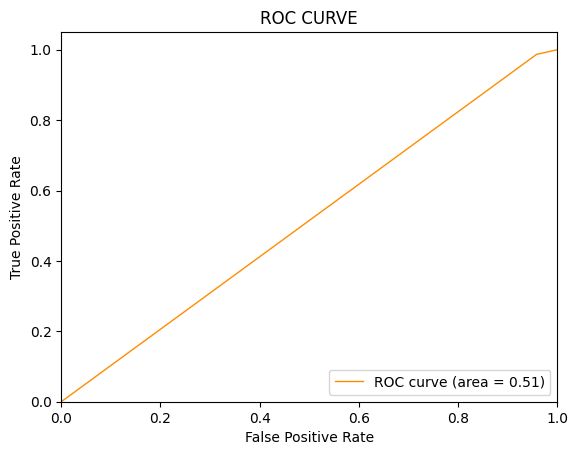

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred3)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()